In [115]:
import matplotlib.pyplot as plt
import csv
import pandas
from matplotlib.backends.backend_pdf import PdfPages
import seaborn
import numpy as np
from pandas.plotting import autocorrelation_plot
seaborn.set()
seaborn.set_style("whitegrid")

The following sets some constants, for comparison

In [116]:
BYTE = 8
GIGA = 1024 * 1024 * 1024

Read the bandwidth measurements:

In [141]:
with open("bw_nfs_measure.csv", "r") as fp:
    df = pandas.read_csv(fp, sep=";", header=None,
                        names=["timestamp",
                               "interface", 
                               "bytes_out/s", 
                               "bytes_in/s",                                
                               "bytes_total/s", 
                               "bytes_in", 
                               "bytes_out", 
                               "packets_out/s", 
                               "packets_in/s", 
                               "packets_total/s", 
                               "packets_in", 
                               "packets_out", 
                               "errors_out/s", 
                               "errors_in/s", 
                               "errors_in", 
                               "errors_out "])
    df = df[df['interface'] == 'ens3']
    df['timestamp'] = pandas.to_datetime(df['timestamp'], unit='s')
    df = df[:-1500] # Drop the boring samples at the end 
    df['gbit/s'] =  df['bytes_out/s'] * BYTE / GIGA
    df.set_index('timestamp', inplace=True)

Convert it to a time series and compute rolling medians across it:

In [142]:
ts = pandas.Series(df['gbit/s'])

rolling = ts.rolling(center=False, window=50).median()

Export it as a PDF plot for the report:

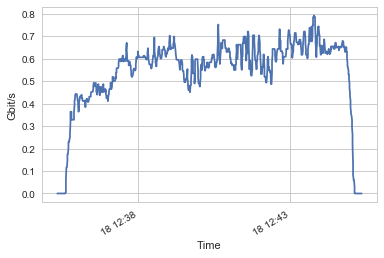

In [143]:
with PdfPages("latex_report/rolling.pdf") as pp:
    ax = rolling.plot()
    #ax.set_ybound(0, 1)
    ax.set_ylabel("Gbit/s")
    ax.set_xlabel("Time")
    pp.savefig()

Compute an autocorrelation plot of the data:

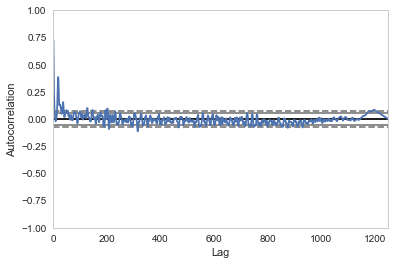

In [144]:
autocorrelation_plot(ts)

Compute the density function of the transfer speed:

Text(0.5,0,'Gbit/s')

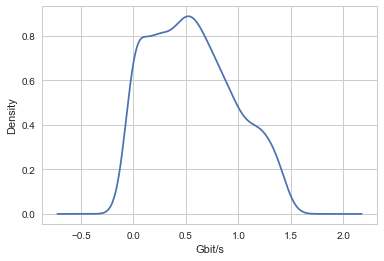

In [145]:
ax = df['gbit/s'].plot.kde()
ax.set_xlabel("Gbit/s")

## Result analysis
The following cells analyse the results of the measurements.

In [150]:
FORMAT_OPTIONS = {'sep': ";", 'header': None, 'names': ["workers", "runtime"]}

In [162]:
with open("runtimes.hdfs", "r") as fp:
    hdfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

First, perhaps most importantly, we need to calculate the standard error mean (in seconds):

In [166]:
hdfs_runtimes[hdfs_runtimes['workers'] == 10].sem()[1]

13.473641991615295

In [167]:
with open("runtimes.nfs", "r") as fp:
    nfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

In [168]:
nfs_runtimes[nfs_runtimes['workers'] == 10].sem()[1]

22.71223669095897

Plot the results. Note that the `x_estimator` argument collects multiple data points and adds error bars to the plot!

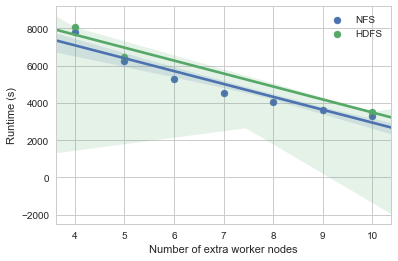

In [169]:
with PdfPages("latex_report/scaling.pdf") as pp:
    fig, ax = plt.subplots(1, 1)
    CHART_OPTIONS = {'x': "workers", 'y': "runtime",
                     'x_estimator': np.mean, 'ax': ax}
    seaborn.regplot(data=nfs_runtimes, label="NFS", **CHART_OPTIONS)
    seaborn.regplot(data=hdfs_runtimes, label="HDFS", **CHART_OPTIONS);
    ax.legend()
    ax.set_xlabel("Number of extra worker nodes")
    ax.set_ylabel("Runtime (s)")
    pp.savefig()